In [2]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import layers
from keras import models
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
from utils import mnist_reader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import classification_report


In [3]:
# Loading data
X_train_val, y_train_val = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=101)
X_test, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')

# Reshape and normalize data
X_train = X_train.reshape((len(X_train), 28, 28, 1)) # 1 as the images are gray scale, 28x28 pixels
X_train = X_train / 255.
X_val = X_val.reshape((len(X_val), 28, 28, 1))
X_val = X_val / 255.
X_test = X_test.reshape((len(X_test), 28, 28, 1))
X_test = X_test / 255.
# One-hot encode y-labels
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)
# Categories:
class_names = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle boot'}

nbr of training samples of T-shirt/top is 4773
nbr of training samples of Trouser is 4856
nbr of training samples of Pullover is 4803
nbr of training samples of Dress is 4808
nbr of training samples of Coat is 4791
nbr of training samples of Sandal is 4809
nbr of training samples of Shirt is 4746
nbr of training samples of Sneaker is 4830
nbr of training samples of Bag is 4820
nbr of training samples of Ankle boot is 4764


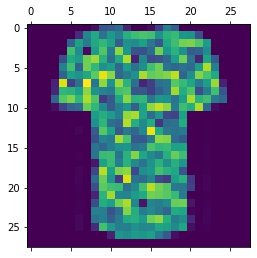

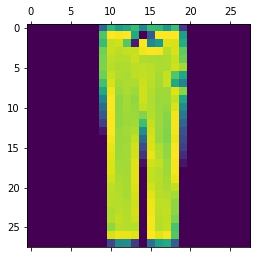

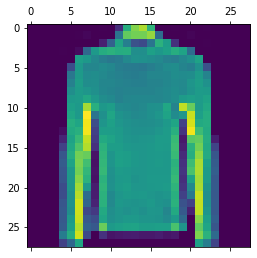

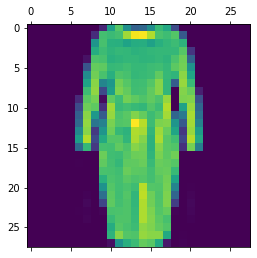

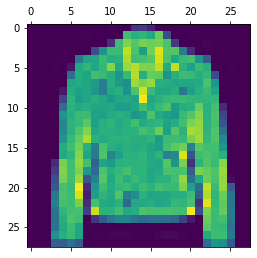

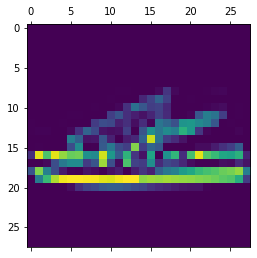

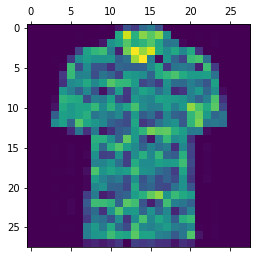

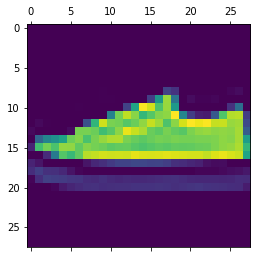

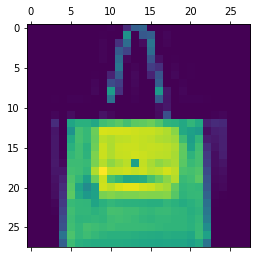

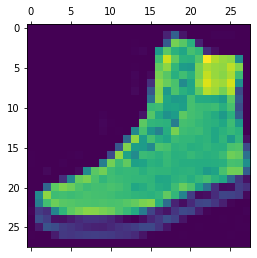

In [4]:
# Exploring the data - 10 classes, number of training samples is 48 000
classes = set(y_train)
for class_ in classes:
    class_indx = [i for i in range(len(y_train)) if y_train[i] == class_]
    print("nbr of training samples of", class_names[class_], "is", len(class_indx))
    X_class_example = X_train[class_indx[1]]
    plt.matshow(np.reshape(X_class_example, (28, 28)))


In [17]:
# Basic model for the NN
model = models.Sequential()
# Conv net
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()
#Compile model
model.compile(loss='categorical_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [18]:
# Callbacks list
callbacks_list = [
    EarlyStopping(
    monitor='acc',
    patience=5,
    ),
    ModelCheckpoint(
    filepath='my_model.h5',
    monitor='val_loss',
    save_best_only=True,
    )
]
# Train model
model.fit(X_train, y_train_cat, 
          epochs=100, 
          batch_size=64,
          callbacks=callbacks_list,
          validation_data=(X_val, y_val_cat))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 20s 423us/step - loss: 1.2927 - acc: 0.5503 - val_loss: 0.7089 - val_acc: 0.7447
Epoch 2/100
48000/48000 [==============================] - 22s 458us/step - loss: 0.7585 - acc: 0.7275 - val_loss: 0.5901 - val_acc: 0.7743
Epoch 3/100
48000/48000 [==============================] - 22s 459us/step - loss: 0.6552 - acc: 0.7610 - val_loss: 0.5328 - val_acc: 0.7978
Epoch 4/100
48000/48000 [==============================] - 22s 451us/step - loss: 0.5992 - acc: 0.7805 - val_loss: 0.4981 - val_acc: 0.8187
Epoch 5/100
48000/48000 [==============================] - 22s 453us/step - loss: 0.5617 - acc: 0.7951 - val_loss: 0.4716 - val_acc: 0.8255
Epoch 6/100
48000/48000 [==============================] - 20s 426us/step - loss: 0.5349 - acc: 0.8046 - val_loss: 0.4519 - val_acc: 0.8346
Epoch 7/100
48000/48000 [==============================] - 20s 421us/step - loss: 0.5097 - acc: 0.8138 - val_l

In [24]:
best_model = load_model('my_model.h5')
predictions = best_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_test_ = np.argmax(y_test_cat, axis=1)
print(classification_report(y_test_, y_pred, target_names=list(class_names.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.88      0.86      0.87      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.84      0.88      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.74      0.71      0.72      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

